In [450]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("../.venv/lib/python3.9/site-packages/")
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [451]:
from typing import Any, List

import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel, norm

from scripts.formatting import set_size
from sklearn.linear_model import BayesianRidge

from coordination.model.beta_coordination_blending_latent_vocalics import BetaCoordinationBlendingLatentVocalics
from coordination.model.utils.coordination_blending_latent_vocalics import LatentVocalicsDataset

In [452]:
PLOTS_DIR = "/Users/paulosoares/manuscript/experimental_agenda/figures"

def save_plot(fig: Any, name: str):
    fig.savefig(f"{PLOTS_DIR}/{name}.pdf", format='pdf', bbox_inches='tight')

In [565]:
def load_datasets(advisor: str):
    with open(f"/Users/paulosoares/data/study-3_2022/datasets/{advisor}/mission1_dataset.pkl", "rb") as f:
        mission1_dataset = pickle.load(f)
    
    with open(f"/Users/paulosoares/data/study-3_2022/datasets/{advisor}/mission2_dataset.pkl", "rb") as f:
        mission2_dataset = pickle.load(f)
    
    with open(f"/Users/paulosoares/data/study-3_2022/datasets/{advisor}/all_missions_dataset.pkl", "rb") as f:
        all_missions_dataset = pickle.load(f)
    
    return mission1_dataset, mission2_dataset, all_missions_dataset

def load_model_inferences(advisor: str, ref_date: str, training_type: str):
    with open(f"/Users/paulosoares/data/study-3_2022/inferences/beta_gaussian/{advisor}/{training_type}/mission1/{ref_date}/inference_summaries.pkl", "rb") as f:
        mission1_summaries = pickle.load(f)
    
    with open(f"/Users/paulosoares/data/study-3_2022/inferences/beta_gaussian/{advisor}/{training_type}/mission2/{ref_date}/inference_summaries.pkl", "rb") as f:
        mission2_summaries = pickle.load(f)
    
    with open(f"/Users/paulosoares/data/study-3_2022/inferences/beta_gaussian/{advisor}/{training_type}/all_missions/{ref_date}/inference_summaries.pkl", "rb") as f:
        all_missions_summaries = pickle.load(f)
    
    return mission1_summaries, mission2_summaries, all_missions_summaries

def plot_regression(ax, coordination: np.ndarray, outcome_measure: np.ndarray, measure_label: str, measure_lim: List[int]):
    reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
    reg.set_params(alpha_init=1e-6, lambda_init=1)
    reg.fit(coordination[:, np.newaxis], outcome_measure)
    
    xs = np.linspace(0,1,100)
    y_mean, y_std = reg.predict(xs[:, np.newaxis], return_std=True)
    
    ax.scatter(coordination, outcome_measure, s=30, alpha=0.7, color="tab:blue")
    ax.plot(xs, y_mean, color="red", label="predict mean")
    ax.fill_between(xs, y_mean - y_std, y_mean + y_std, color="tab:pink", alpha=0.5)
    ax.set_xlabel(r"Coordination")
    ax.set_ylabel(measure_label)
    ax.set_xlim([0, 1])
    ax.set_ylim(measure_lim)

In [567]:
# Loading all datasets
no_m1_dataset, no_m2_dataset, no_all_dataset = load_datasets("no_advisor")
human_m1_dataset, human_m2_dataset, human_all_dataset = load_datasets("human_advisor")
tomcat_m1_dataset, tomcat_m2_dataset, tomcat_all_dataset = load_datasets("tomcat_advisor")
m1_dataset, m2_dataset, all_dataset = load_datasets("all_conditions")

In [568]:
# Loading all model inference summaries
REF_DATE = "2022.12.02--15"
TRAINING_TYPE = "single_execution"

no_m1_summaries, no_m2_summaries, no_all_summaries = load_model_inferences("no_advisor", REF_DATE, TRAINING_TYPE)
human_m1_summaries, human_m2_summaries, human_all_summaries = load_model_inferences("human_advisor", REF_DATE, TRAINING_TYPE)
tomcat_m1_summaries, tomcat_m2_summaries, tomcat_all_summaries = load_model_inferences("tomcat_advisor", REF_DATE, TRAINING_TYPE)
m1_summaries, m2_summaries, all_summaries = load_model_inferences("all_conditions", REF_DATE, TRAINING_TYPE)

In [569]:
from functools import partial
AGGR_FN = np.mean
# AGGR_FN = np.max
# AGGR_FN = np.var
# AGGR_FN = partial(np.percentile, q=75)

# No Advisor

In [570]:
# Use average estimated coordination in each trial
no_m1_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in no_m1_summaries])
no_m2_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in no_m2_summaries])
no_all_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in no_all_summaries])

## Coordination vs Team Score

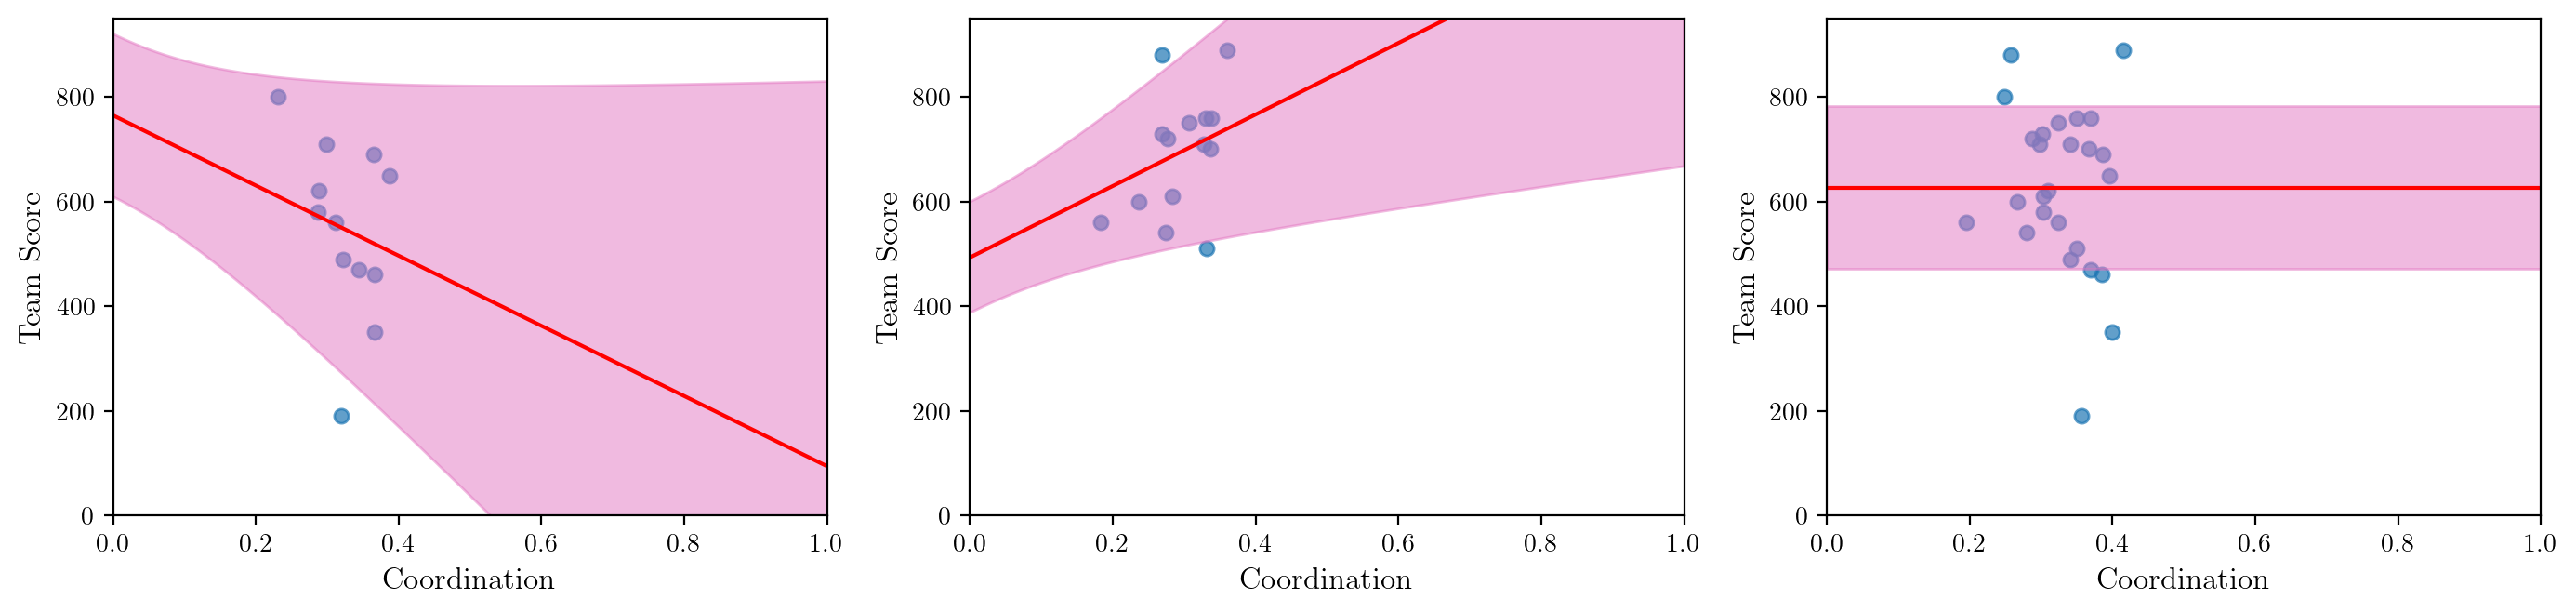

In [573]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=4, subplots=(1,3)))
plot_regression(ax[0], no_m1_avg_coordination, [s.team_score for s in no_m1_dataset.series], "Team Score", [0, 950])
plot_regression(ax[1], no_m2_avg_coordination, [s.team_score for s in no_m2_dataset.series], "Team Score", [0, 950])
plot_regression(ax[2], no_all_avg_coordination, [s.team_score for s in no_all_dataset.series], "Team Score", [0, 950])

## Coordination vs Team Process Scale

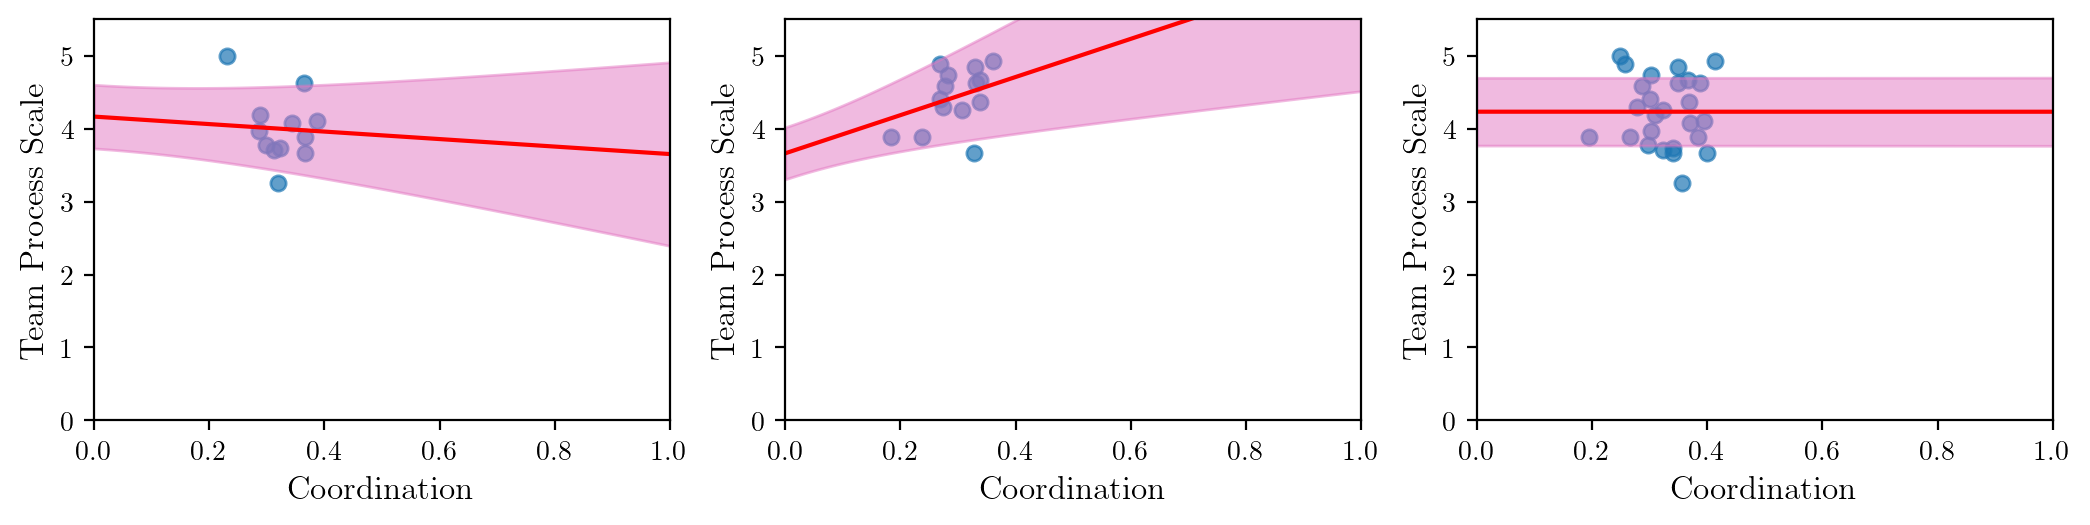

In [574]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], no_m1_avg_coordination, [s.team_process_surveys.mean() for s in no_m1_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[1], no_m2_avg_coordination, [s.team_process_surveys.mean() for s in no_m2_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[2], no_all_avg_coordination, [s.team_process_surveys.mean() for s in no_all_dataset.series], "Team Process Scale", [0, 5.5])

## Coordination vs Team Satisfaction

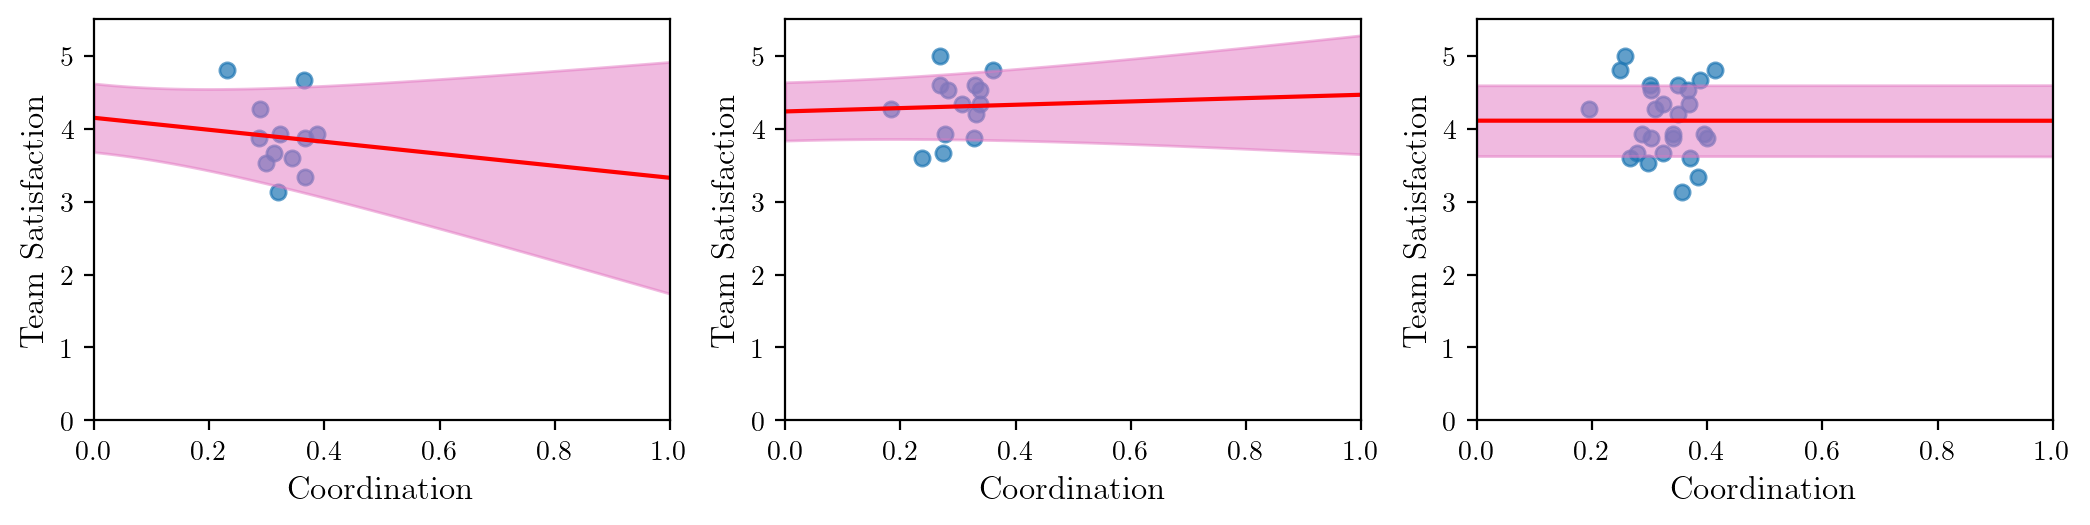

In [575]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], no_m1_avg_coordination, [s.team_satisfaction_surveys.mean() for s in no_m1_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[1], no_m2_avg_coordination, [s.team_satisfaction_surveys.mean() for s in no_m2_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[2], no_all_avg_coordination, [s.team_satisfaction_surveys.mean() for s in no_all_dataset.series], "Team Satisfaction", [0, 5.5])

# Human Advisor

In [576]:
# Use average estimated coordination in each trial
human_m1_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in human_m1_summaries])
human_m2_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in human_m2_summaries])
human_all_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in human_all_summaries])

## Coordination vs Team Score

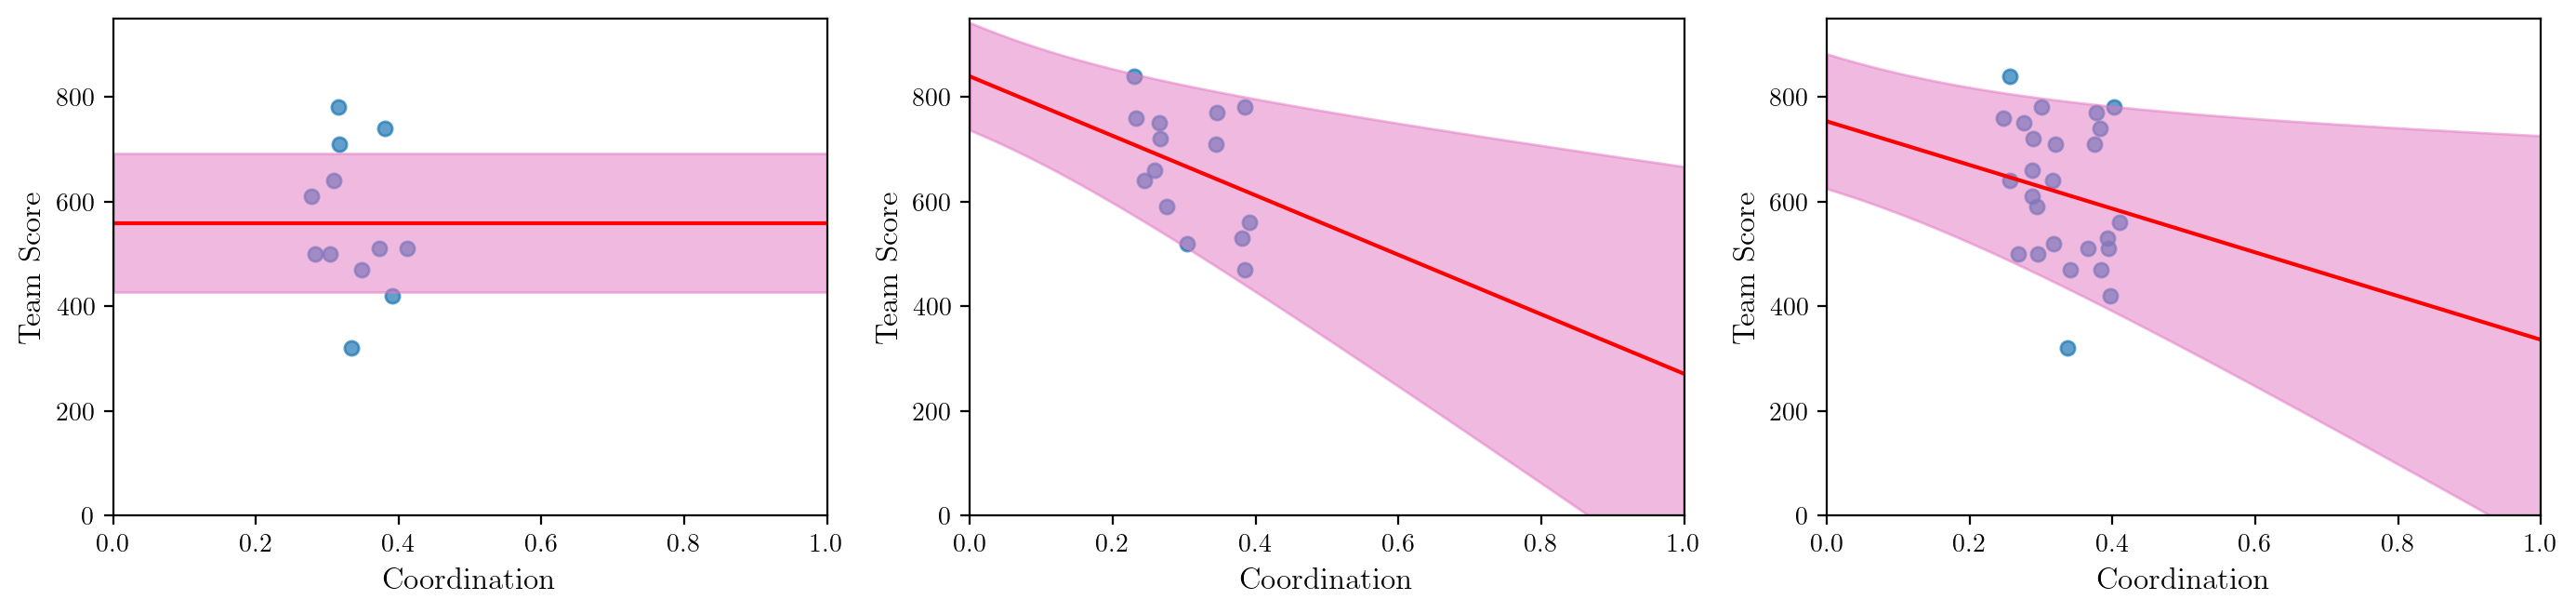

In [577]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=4, subplots=(1,3)))
plot_regression(ax[0], human_m1_avg_coordination, [s.team_score for s in human_m1_dataset.series], "Team Score", [0, 950])
plot_regression(ax[1], human_m2_avg_coordination, [s.team_score for s in human_m2_dataset.series], "Team Score", [0, 950])
plot_regression(ax[2], human_all_avg_coordination, [s.team_score for s in human_all_dataset.series], "Team Score", [0, 950])

## Coordination vs Team Process Scale

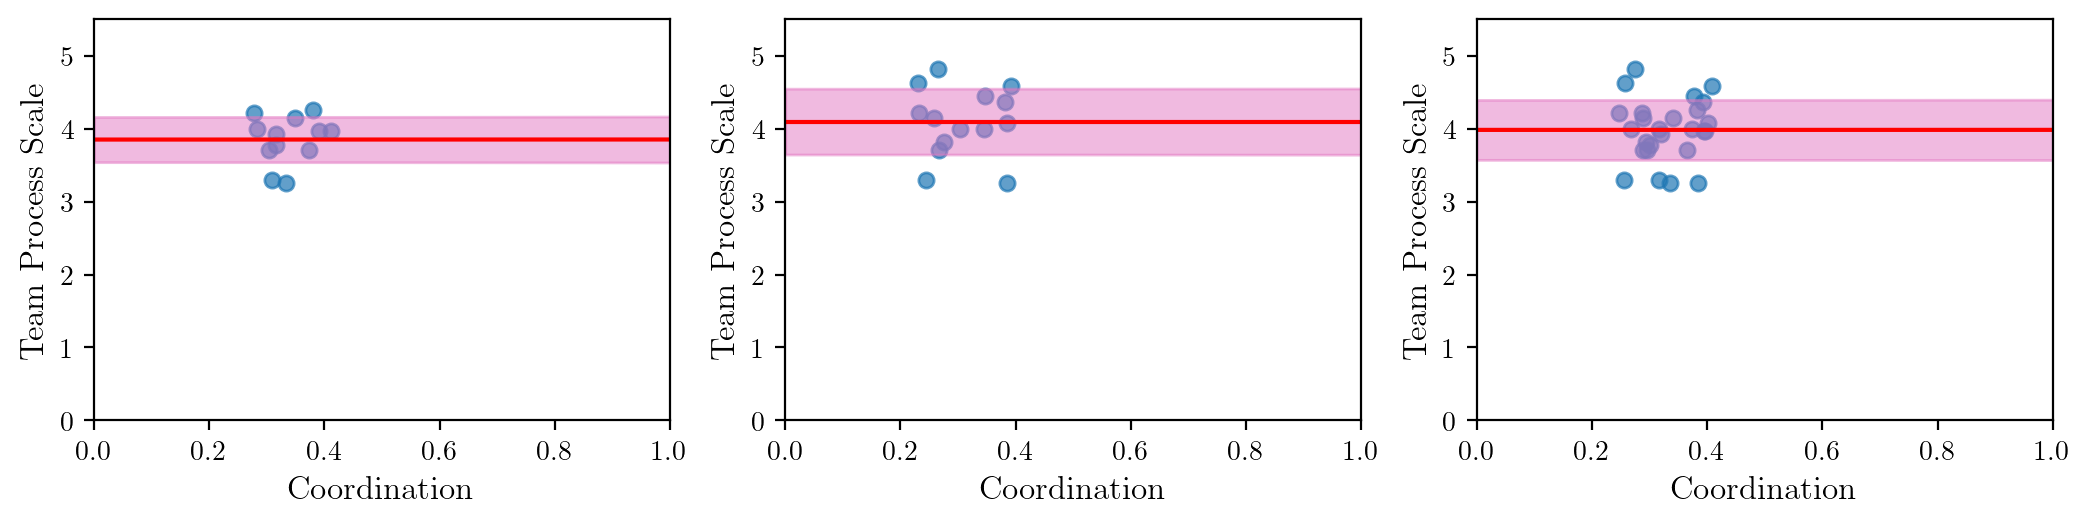

In [578]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], human_m1_avg_coordination, [s.team_process_surveys.mean() for s in human_m1_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[1], human_m2_avg_coordination, [s.team_process_surveys.mean() for s in human_m2_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[2], human_all_avg_coordination, [s.team_process_surveys.mean() for s in human_all_dataset.series], "Team Process Scale", [0, 5.5])

## Coordination vs Team Satisfaction

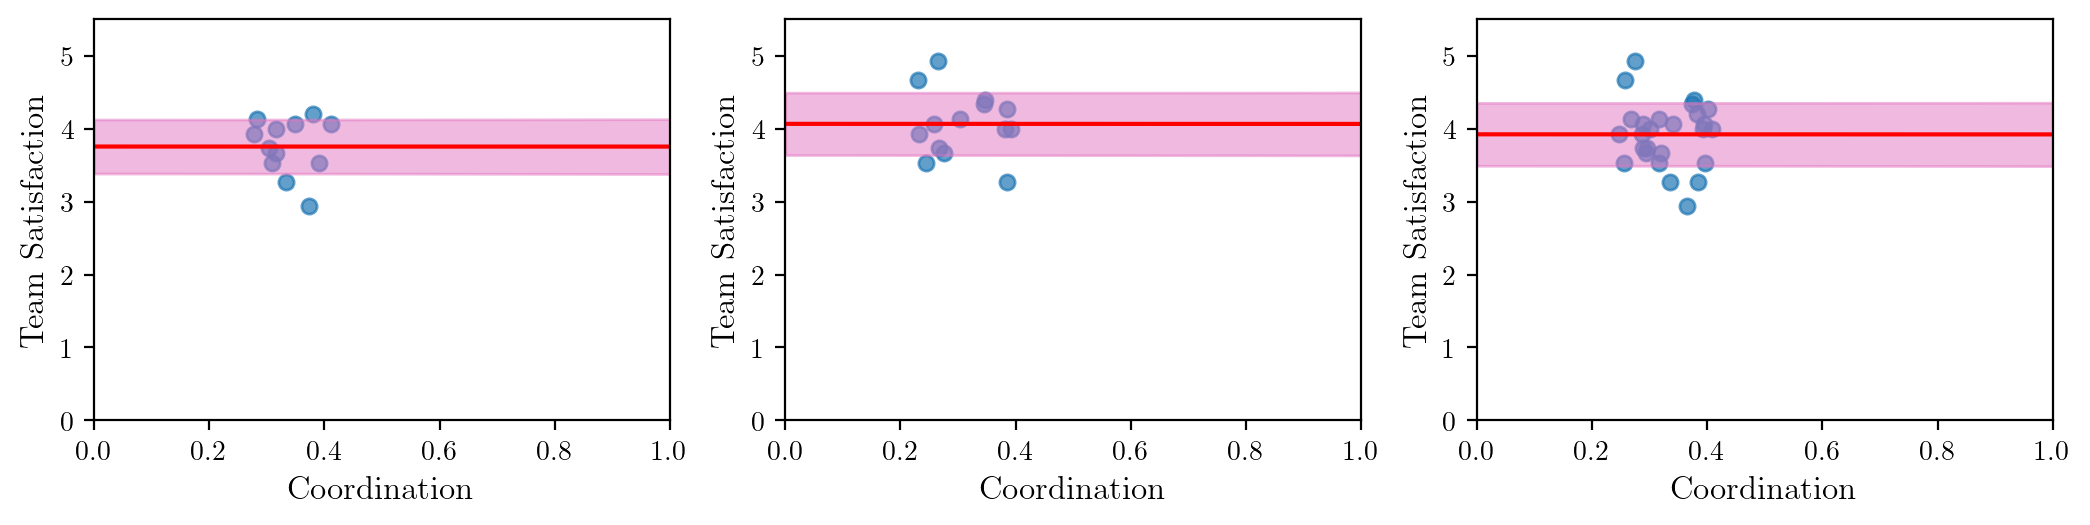

In [586]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], human_m1_avg_coordination, [s.team_satisfaction_surveys.mean() for s in human_m1_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[1], human_m2_avg_coordination, [s.team_satisfaction_surveys.mean() for s in human_m2_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[2], human_all_avg_coordination, [s.team_satisfaction_surveys.mean() for s in human_all_dataset.series], "Team Satisfaction", [0, 5.5])

# ToMCAT Advisor

In [541]:
# Use average estimated coordination in each trial
tomcat_m1_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in tomcat_m1_summaries])
tomcat_m2_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in tomcat_m2_summaries])
tomcat_all_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in tomcat_all_summaries])

## Coordination vs Team Score

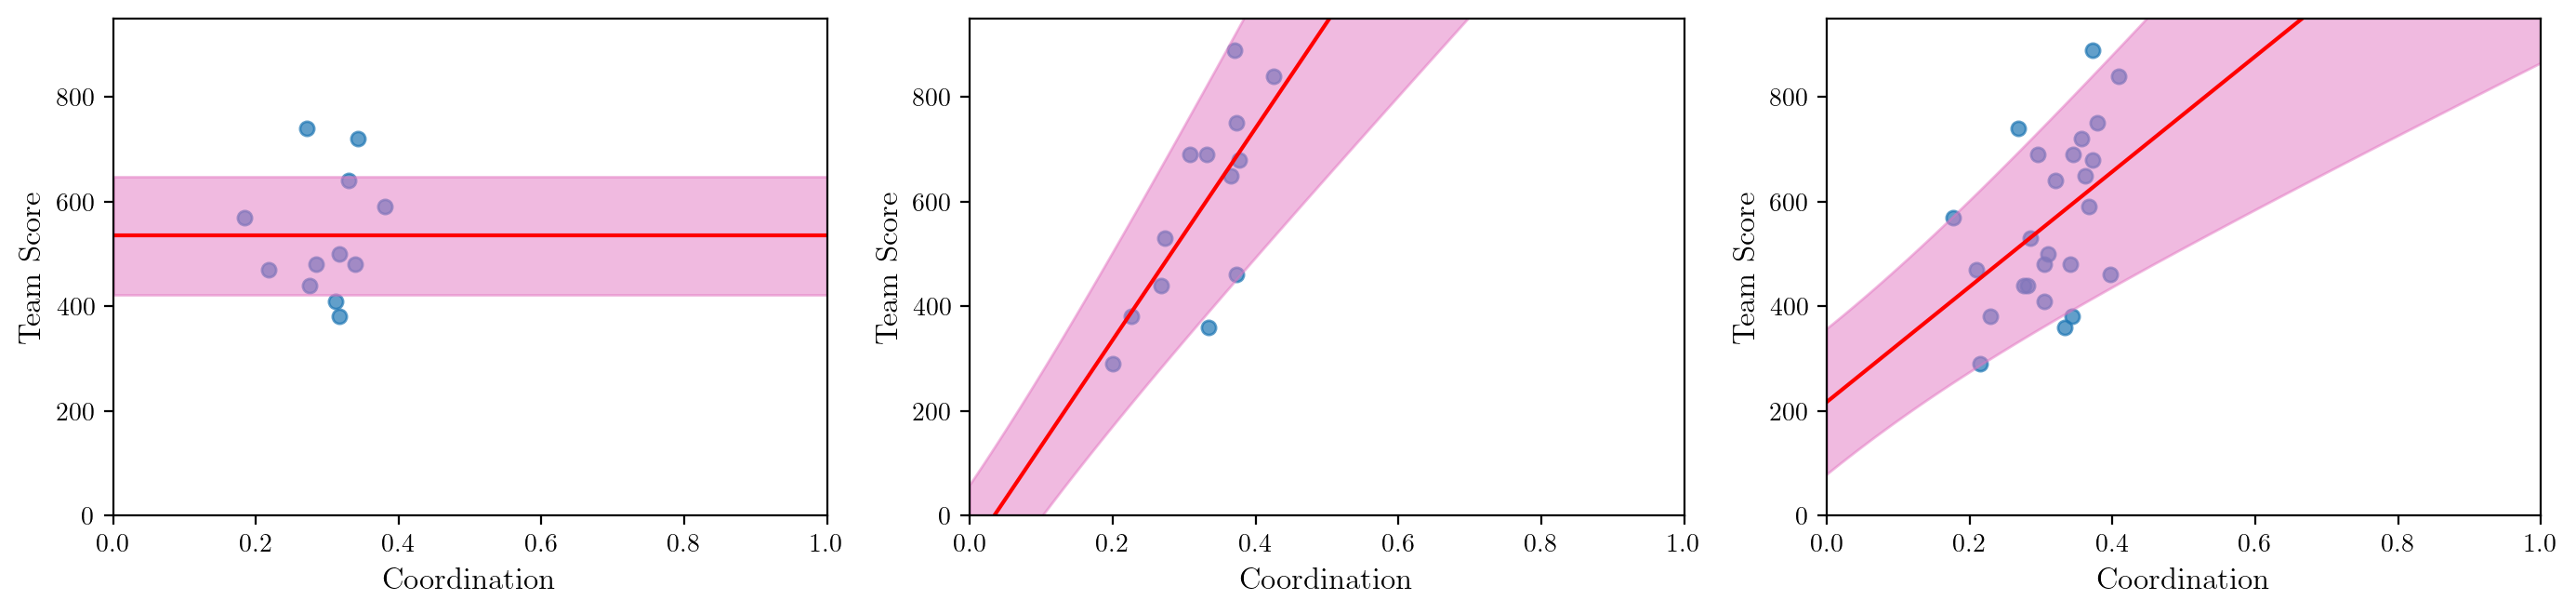

In [589]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=4, subplots=(1,3)))
plot_regression(ax[0], tomcat_m1_avg_coordination, [s.team_score for s in tomcat_m1_dataset.series], "Team Score", [0, 950])
plot_regression(ax[1], tomcat_m2_avg_coordination, [s.team_score for s in tomcat_m2_dataset.series], "Team Score", [0, 950])
plot_regression(ax[2], tomcat_all_avg_coordination, [s.team_score for s in tomcat_all_dataset.series], "Team Score", [0, 950])

## Coordination vs Team Process Scale

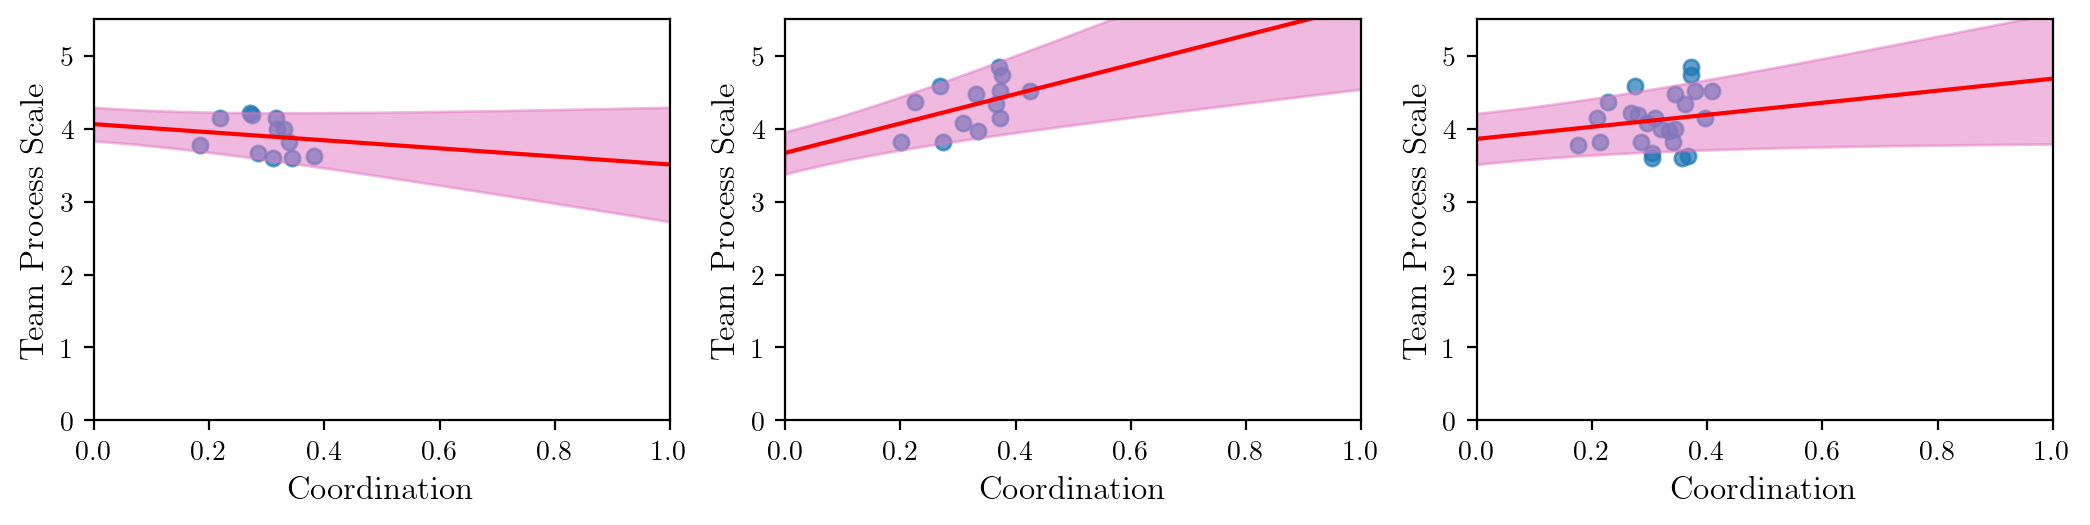

In [587]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], tomcat_m1_avg_coordination, [s.team_process_surveys.mean() for s in tomcat_m1_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[1], tomcat_m2_avg_coordination, [s.team_process_surveys.mean() for s in tomcat_m2_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[2], tomcat_all_avg_coordination, [s.team_process_surveys.mean() for s in tomcat_all_dataset.series], "Team Process Scale", [0, 5.5])

## Coordination vs Team Satisfaction

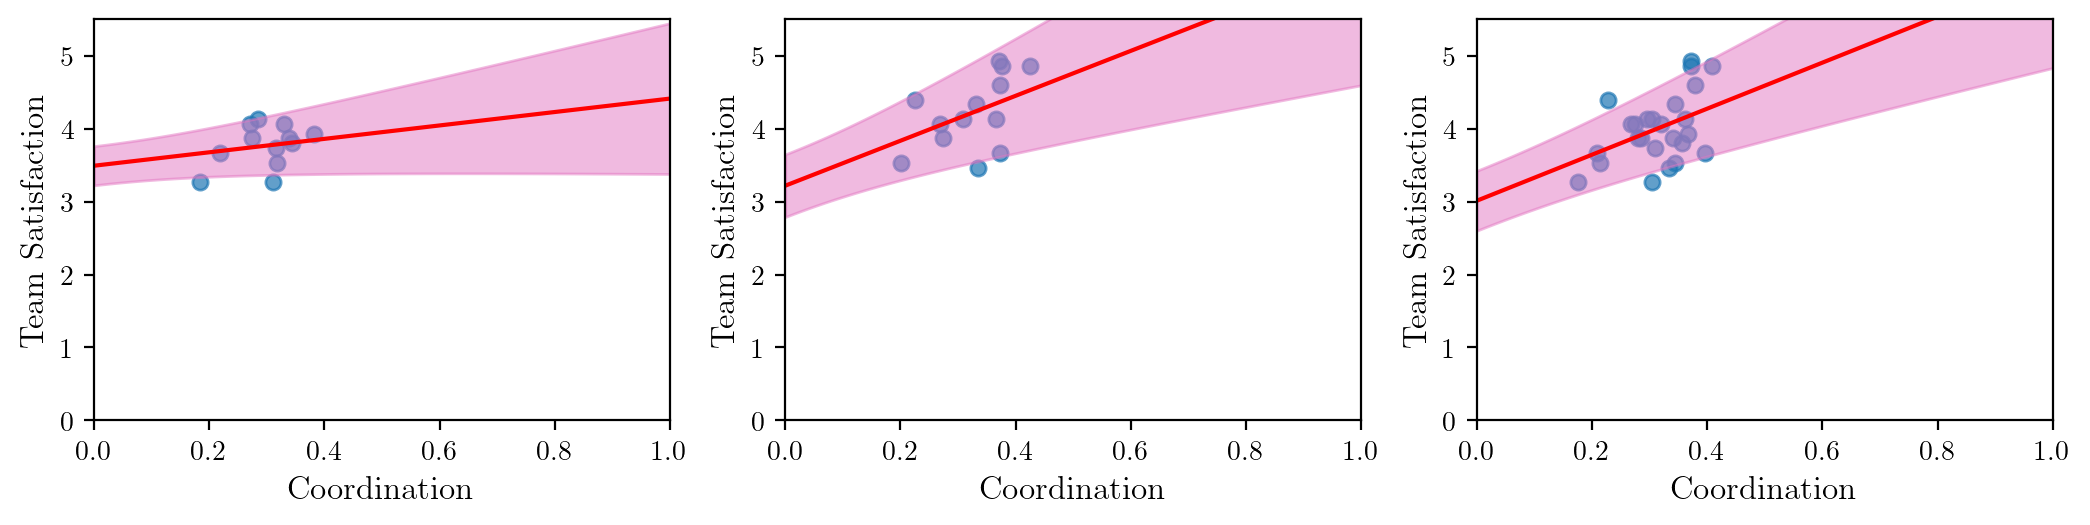

In [585]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], tomcat_m1_avg_coordination, [s.team_satisfaction_surveys.mean() for s in tomcat_m1_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[1], tomcat_m2_avg_coordination, [s.team_satisfaction_surveys.mean() for s in tomcat_m2_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[2], tomcat_all_avg_coordination, [s.team_satisfaction_surveys.mean() for s in tomcat_all_dataset.series], "Team Satisfaction", [0, 5.5])

# All Conditions

In [580]:
# Use average estimated coordination in each trial
m1_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in m1_summaries])
m2_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in m2_summaries])
all_avg_coordination = np.array([AGGR_FN(summary.coordination_mean) for summary in all_summaries])

## Coordination vs Team Score

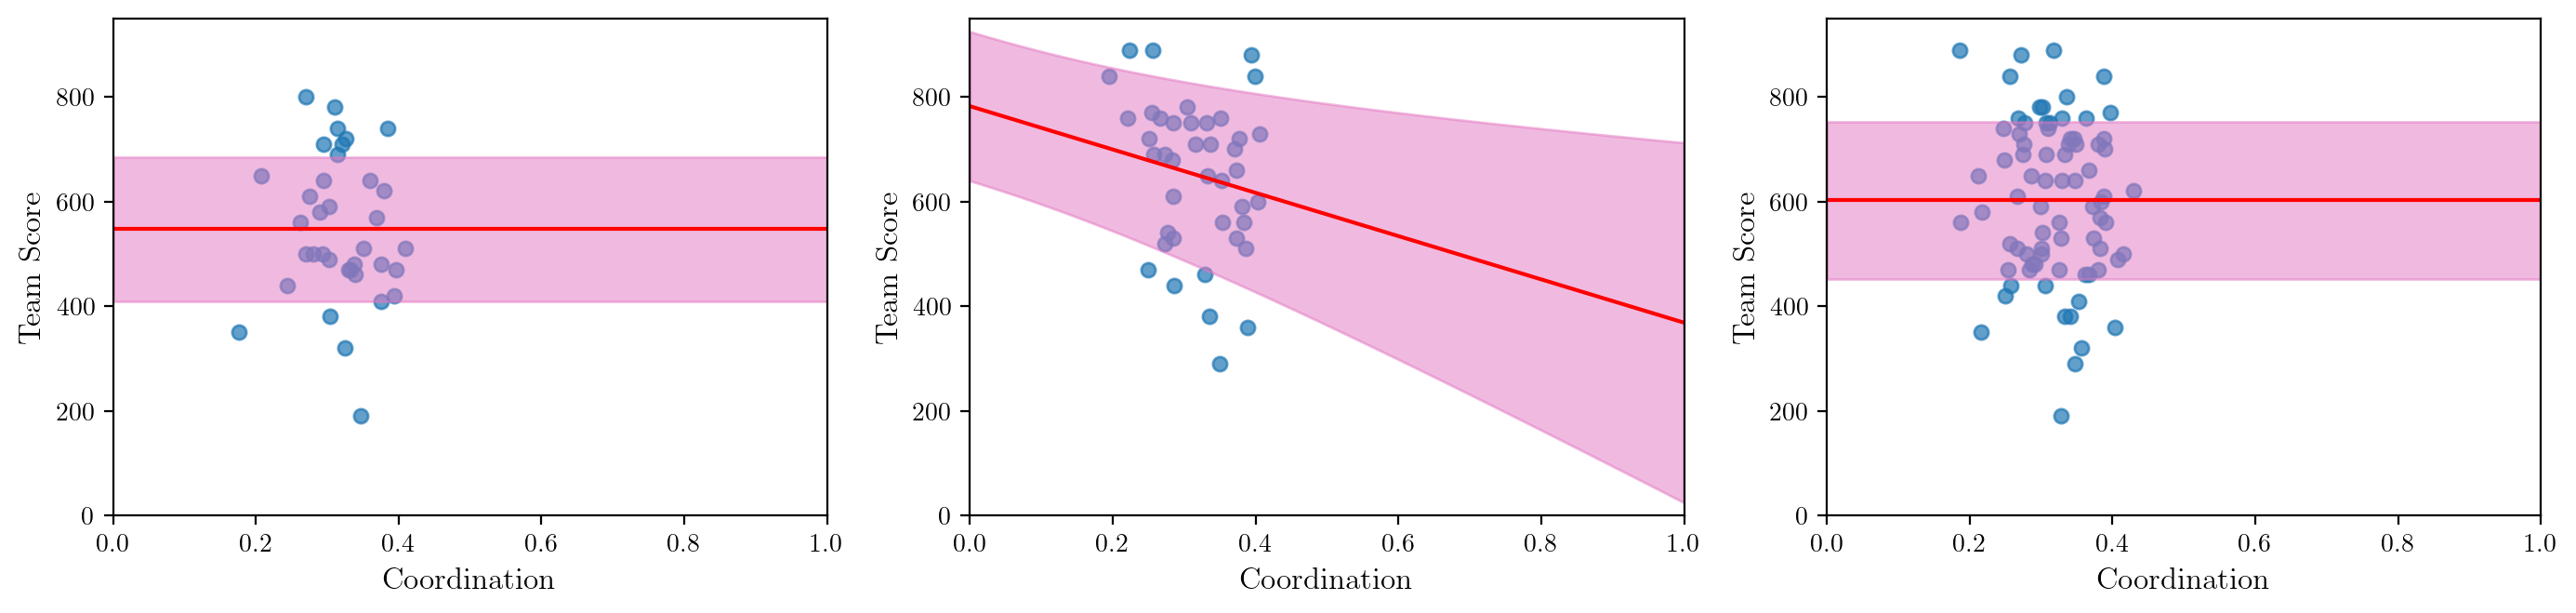

In [590]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=4, subplots=(1,3)))
plot_regression(ax[0], m1_avg_coordination, [s.team_score for s in m1_dataset.series], "Team Score", [0, 950])
plot_regression(ax[1], m2_avg_coordination, [s.team_score for s in m2_dataset.series], "Team Score", [0, 950])
plot_regression(ax[2], all_avg_coordination, [s.team_score for s in all_dataset.series], "Team Score", [0, 950])

## Coordination vs Team Process Scale

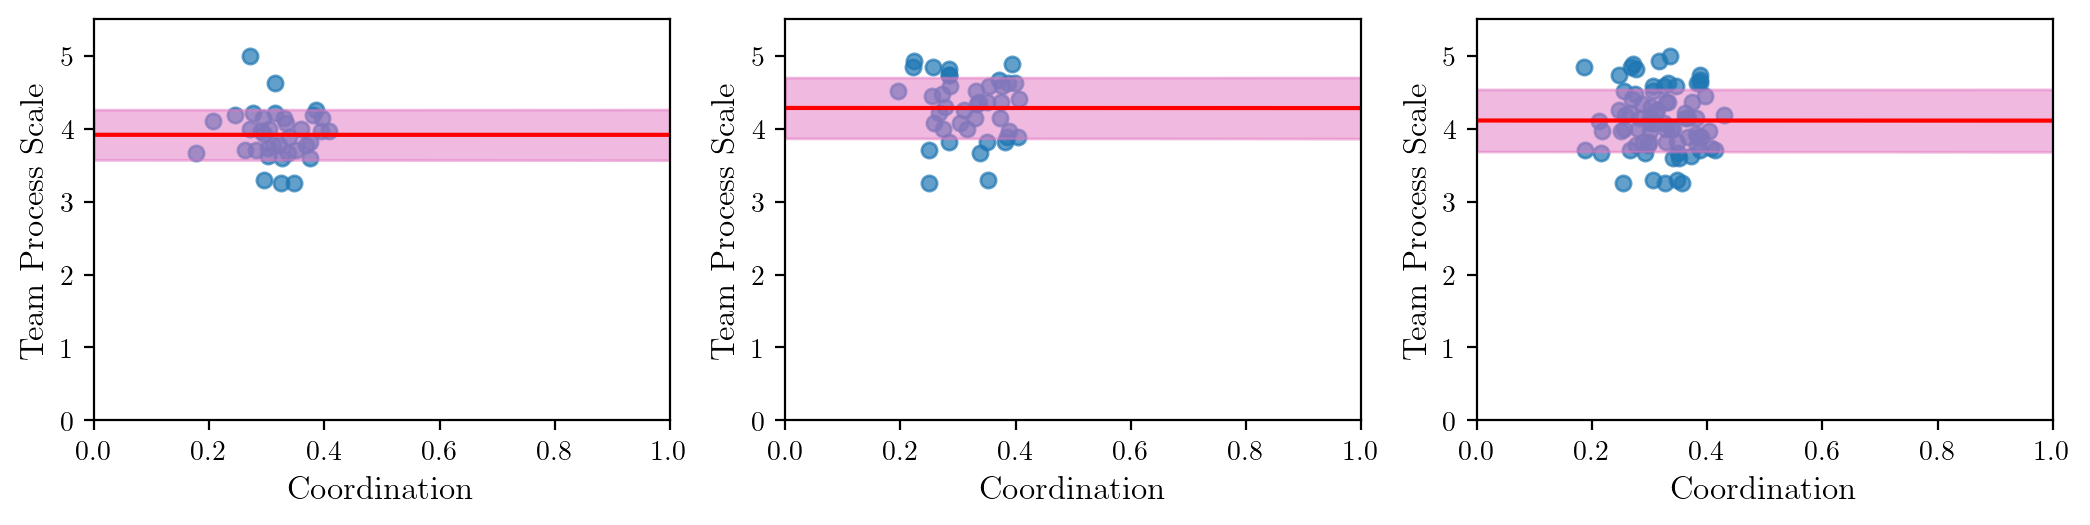

In [588]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], m1_avg_coordination, [s.team_process_surveys.mean() for s in m1_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[1], m2_avg_coordination, [s.team_process_surveys.mean() for s in m2_dataset.series], "Team Process Scale", [0, 5.5])
plot_regression(ax[2], all_avg_coordination, [s.team_process_surveys.mean() for s in all_dataset.series], "Team Process Scale", [0, 5.5])

## Coordination vs Team Satisfaction

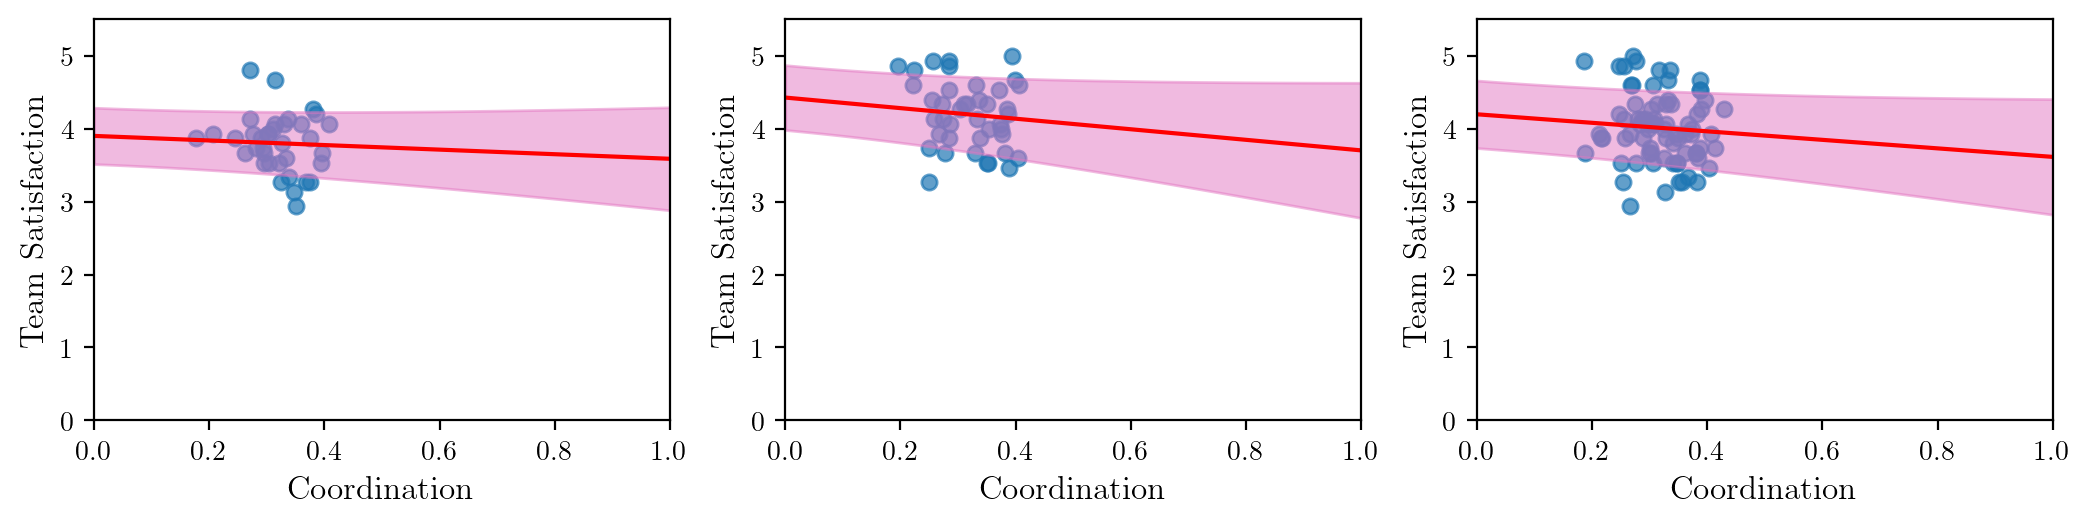

In [584]:
plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 3, figsize=set_size("research_notebook", fraction=3, subplots=(1,3)))
plot_regression(ax[0], m1_avg_coordination, [s.team_satisfaction_surveys.mean() for s in m1_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[1], m2_avg_coordination, [s.team_satisfaction_surveys.mean() for s in m2_dataset.series], "Team Satisfaction", [0, 5.5])
plot_regression(ax[2], all_avg_coordination,[s.team_satisfaction_surveys.mean() for s in all_dataset.series], "Team Satisfaction", [0, 5.5])